# Model Validation Notebook

This notebook contains all validation tests for the model.

## Load the Model

In [346]:
import pysd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

current_dir = Path.cwd()
BASE_DIR = current_dir.parent if current_dir.name == 'notebooks' else current_dir
os.chdir(BASE_DIR)

model = pysd.load('src/model.py')

## Baseline Simulation

The baseline simulation considers two cases that serve different validation roles.

The first case is the **zero tax baseline** (`carbon_tax_rate = 0`). This case is used for structural validation, that is to confirm that the model has a stable behaviour when no forces act on the system and no internal drifts, oscillations or odd dynamics occur.

The second case is the **real world baseline** (`carbon_tax_rate = 289`). This case is used for qualitatative validation, that is to confirm that the behaviour is realistic in the real-world policy environment.

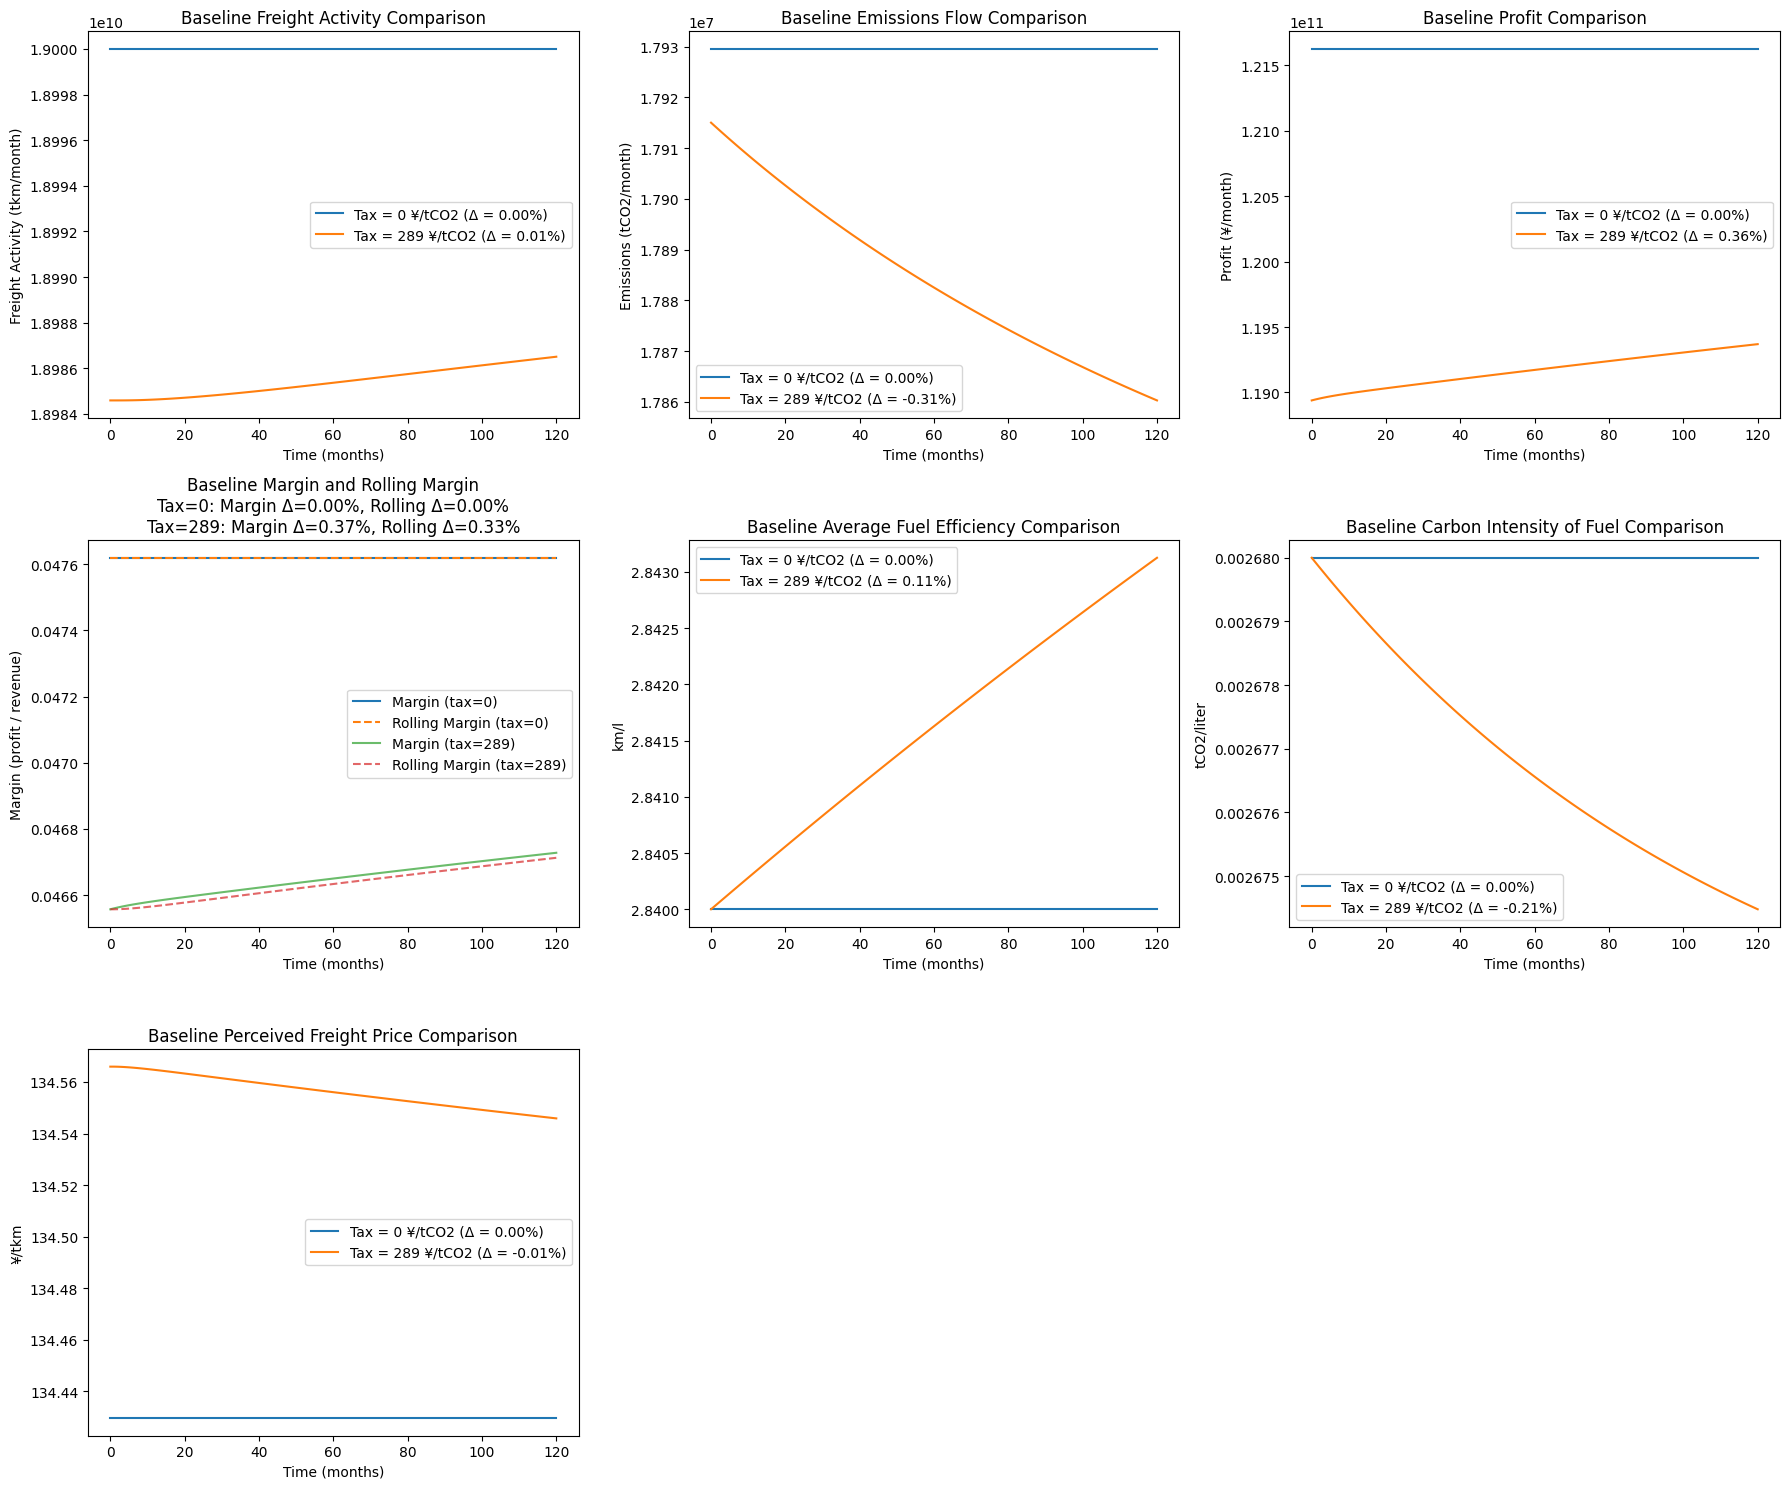

In [347]:
baseline_scenarios = {
    "theoretical": 0,
    "current": 289
}
return_columns=[
    "freight_activity",
    "profit",
    "margin",
    "rolling_margin",
    "cumulative_profit",
    "emissions",
    "cumulative_co2",
    "average_fuel_efficiency",
    "carbon_intensity_of_fuel",
    "perceived_freight_price"
]

baseline_results = {}
for scenario_name, scenario_value in baseline_scenarios.items():
    baseline_results[scenario_name] = model.run(
        params={
            "carbon_tax_rate": scenario_value,
        },
        return_columns=return_columns
    )

# Helper function to calculate percentage change
def calc_pct_change(series):
    start_val = series.iloc[0]
    end_val = series.iloc[-1]
    if start_val != 0:
        return ((end_val - start_val) / start_val) * 100
    else:
        return float('inf') if end_val > 0 else 0.0

pct_changes = {}
for scenario_name in baseline_scenarios.keys():
    baseline = baseline_results[scenario_name]
    pct_changes[scenario_name] = {
        "freight_activity": calc_pct_change(baseline["freight_activity"]),
        "emissions": calc_pct_change(baseline["emissions"]),
        "profit": calc_pct_change(baseline["profit"]),
        "margin": calc_pct_change(baseline["margin"]),
        "rolling_margin": calc_pct_change(baseline["rolling_margin"]),
        "average_fuel_efficiency": calc_pct_change(baseline["average_fuel_efficiency"]),
        "carbon_intensity_of_fuel": calc_pct_change(baseline["carbon_intensity_of_fuel"]),
        "perceived_freight_price": calc_pct_change(baseline["perceived_freight_price"])
    }

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for scenario_name, scenario_value in baseline_scenarios.items():
    baseline_results[scenario_name]["freight_activity"].plot(
        ax=axes[0], 
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {pct_changes[scenario_name]['freight_activity']:.2f}%)"
    )
axes[0].set_title("Baseline Freight Activity Comparison")
axes[0].set_xlabel("Time (months)")
axes[0].set_ylabel("Freight Activity (tkm/month)")
axes[0].legend()

for scenario_name, scenario_value in baseline_scenarios.items():
    baseline_results[scenario_name]["emissions"].plot(
        ax=axes[1],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {pct_changes[scenario_name]['emissions']:.2f}%)"
    )
axes[1].set_title("Baseline Emissions Flow Comparison")
axes[1].set_xlabel("Time (months)")
axes[1].set_ylabel("Emissions (tCO2/month)")
axes[1].legend()

for scenario_name, scenario_value in baseline_scenarios.items():
    baseline_results[scenario_name]["profit"].plot(
        ax=axes[2],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {pct_changes[scenario_name]['profit']:.2f}%)"
    )
axes[2].set_title("Baseline Profit Comparison")
axes[2].set_xlabel("Time (months)")
axes[2].set_ylabel("Profit (¥/month)")
axes[2].legend()

theoretical = baseline_results["theoretical"]
current = baseline_results["current"]
theoretical["margin"].plot(ax=axes[3], label="Margin (tax=0)", linestyle="-")
theoretical["rolling_margin"].plot(ax=axes[3], label="Rolling Margin (tax=0)", linestyle="--")
current["margin"].plot(ax=axes[3], label="Margin (tax=289)", linestyle="-", alpha=0.7)
current["rolling_margin"].plot(ax=axes[3], label="Rolling Margin (tax=289)", linestyle="--", alpha=0.7)
axes[3].set_title(f"Baseline Margin and Rolling Margin\nTax=0: Margin Δ={pct_changes['theoretical']['margin']:.2f}%, Rolling Δ={pct_changes['theoretical']['rolling_margin']:.2f}%\nTax=289: Margin Δ={pct_changes['current']['margin']:.2f}%, Rolling Δ={pct_changes['current']['rolling_margin']:.2f}%")
axes[3].set_xlabel("Time (months)")
axes[3].set_ylabel("Margin (profit / revenue)")
axes[3].legend()

for scenario_name, scenario_value in baseline_scenarios.items():
    baseline_results[scenario_name]["average_fuel_efficiency"].plot(
        ax=axes[4],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {pct_changes[scenario_name]['average_fuel_efficiency']:.2f}%)"
    )
axes[4].set_title("Baseline Average Fuel Efficiency Comparison")
axes[4].set_xlabel("Time (months)")
axes[4].set_ylabel("km/l")
axes[4].legend()

for scenario_name, scenario_value in baseline_scenarios.items():
    baseline_results[scenario_name]["carbon_intensity_of_fuel"].plot(
        ax=axes[5],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {pct_changes[scenario_name]['carbon_intensity_of_fuel']:.2f}%)"
    )
axes[5].set_title("Baseline Carbon Intensity of Fuel Comparison")
axes[5].set_xlabel("Time (months)")
axes[5].set_ylabel("tCO2/liter")
axes[5].legend()

for scenario_name, scenario_value in baseline_scenarios.items():
    baseline_results[scenario_name]["perceived_freight_price"].plot(
        ax=axes[6],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {pct_changes[scenario_name]['perceived_freight_price']:.2f}%)"
    )
axes[6].set_title("Baseline Perceived Freight Price Comparison")
axes[6].set_xlabel("Time (months)")
axes[6].set_ylabel("¥/tkm")
axes[6].legend()

for i in range(7, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(f'{BASE_DIR}/figures/baseline_comparison.png')
plt.show()

## Policy Response Tests

The policy response tests is used to further prove behavioural validation. It simulates four different scenarios.

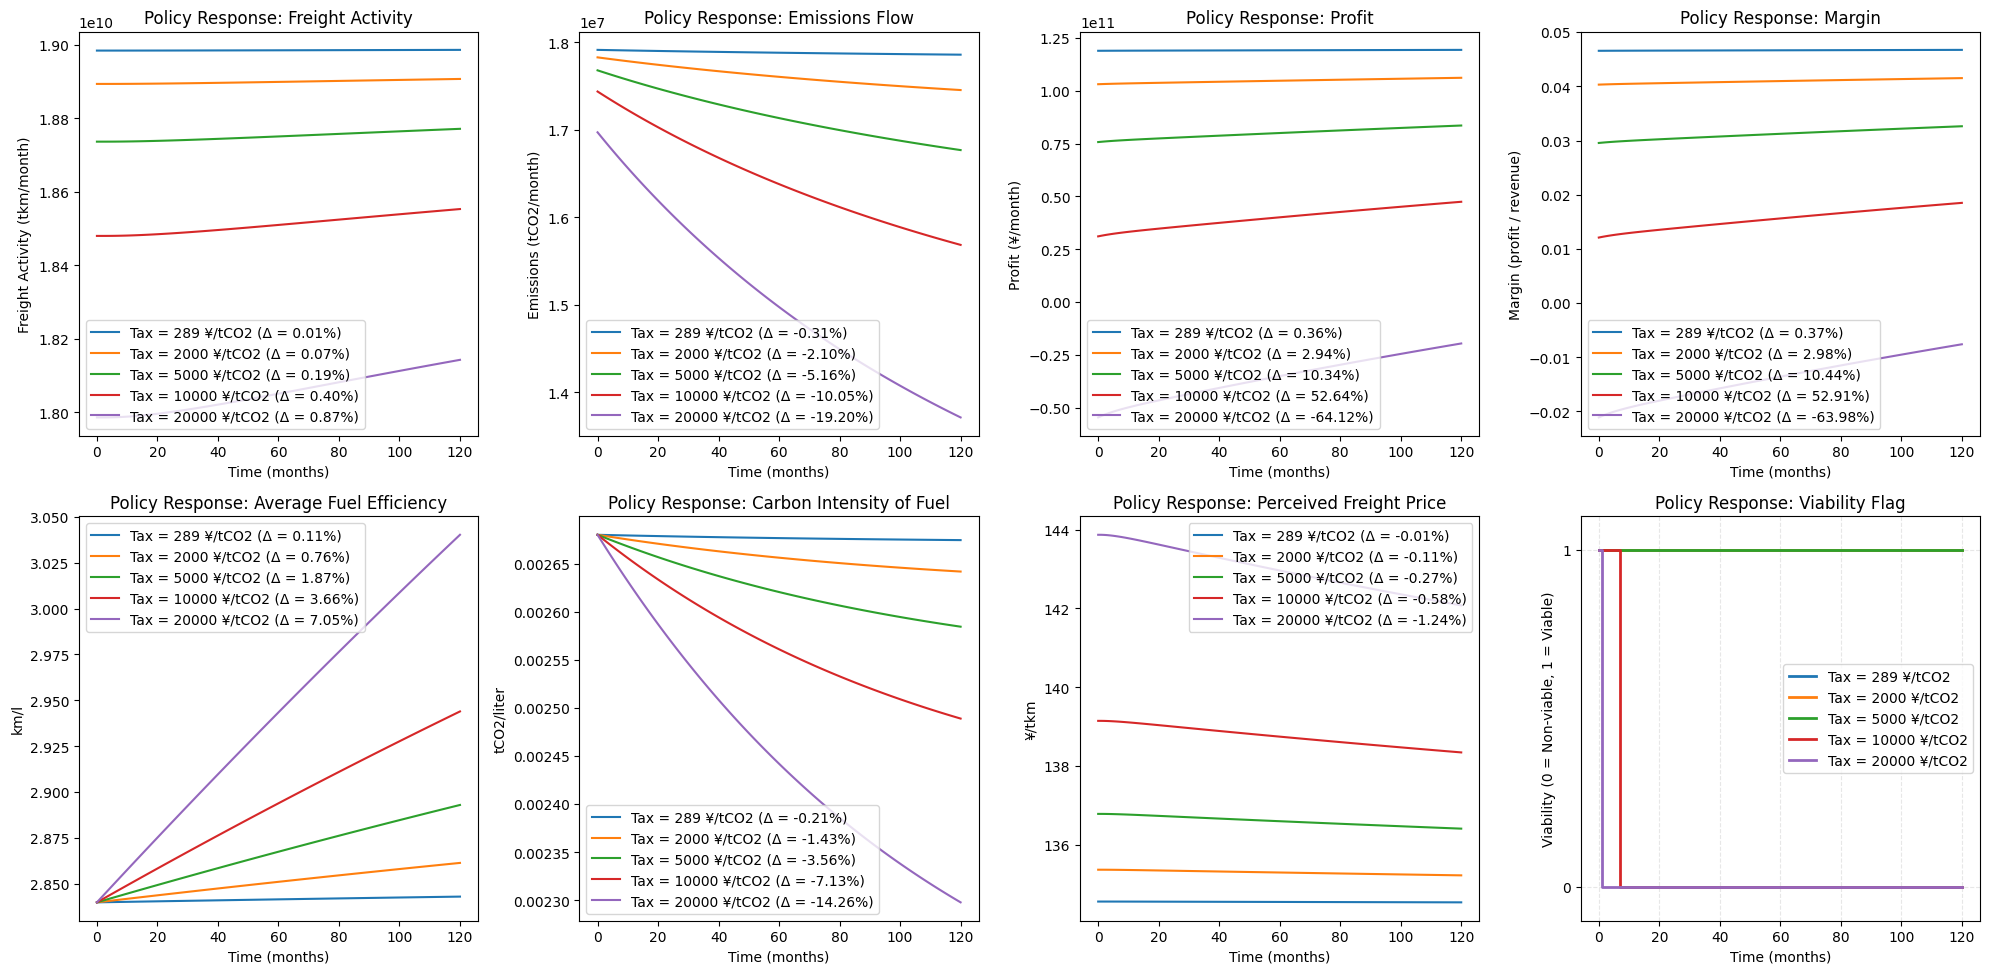

In [348]:
policy_response_scenarios = {
    "baseline": 289,
    "low": 2000,
    "moderate": 5000,
    "strong": 10000,
    "extreme": 20000
}
return_columns=[
    "freight_activity",
    "profit",
    "margin",
    "emissions",
    "perceived_freight_price",
    "average_fuel_efficiency",
    "carbon_intensity_of_fuel",
    "viability_flag"
]

# Run all policy response scenarios and store results
policy_results = {}
for scenario_name, scenario_value in policy_response_scenarios.items():
    policy_results[scenario_name] = model.run(
        params={
            "carbon_tax_rate": scenario_value
        },
        return_columns=return_columns
    )

# Helper function to calculate percentage change
def calc_pct_change(series):
    start_val = series.iloc[0]
    end_val = series.iloc[-1]
    if start_val != 0:
        return ((end_val - start_val) / start_val) * 100
    else:
        return float('inf') if end_val > 0 else 0.0

# Calculate percentage changes for all scenarios
policy_pct_changes = {}
for scenario_name in policy_response_scenarios.keys():
    result = policy_results[scenario_name]
    policy_pct_changes[scenario_name] = {
        "freight_activity": calc_pct_change(result["freight_activity"]),
        "emissions": calc_pct_change(result["emissions"]),
        "profit": calc_pct_change(result["profit"]),
        "margin": calc_pct_change(result["margin"]),
        "perceived_freight_price": calc_pct_change(result["perceived_freight_price"]),
        "average_fuel_efficiency": calc_pct_change(result["average_fuel_efficiency"]),
        "carbon_intensity_of_fuel": calc_pct_change(result["carbon_intensity_of_fuel"])
    }

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for scenario_name, scenario_value in policy_response_scenarios.items():
    policy_results[scenario_name]["freight_activity"].plot(
        ax=axes[0],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {policy_pct_changes[scenario_name]['freight_activity']:.2f}%)"
    )
axes[0].set_title("Policy Response: Freight Activity")
axes[0].set_xlabel("Time (months)")
axes[0].set_ylabel("Freight Activity (tkm/month)")
axes[0].legend()

for scenario_name, scenario_value in policy_response_scenarios.items():
    policy_results[scenario_name]["emissions"].plot(
        ax=axes[1],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {policy_pct_changes[scenario_name]['emissions']:.2f}%)"
    )
axes[1].set_title("Policy Response: Emissions Flow")
axes[1].set_xlabel("Time (months)")
axes[1].set_ylabel("Emissions (tCO2/month)")
axes[1].legend()

for scenario_name, scenario_value in policy_response_scenarios.items():
    policy_results[scenario_name]["profit"].plot(
        ax=axes[2],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {policy_pct_changes[scenario_name]['profit']:.2f}%)"
    )
axes[2].set_title("Policy Response: Profit")
axes[2].set_xlabel("Time (months)")
axes[2].set_ylabel("Profit (¥/month)")
axes[2].legend()

for scenario_name, scenario_value in policy_response_scenarios.items():
    policy_results[scenario_name]["margin"].plot(
        ax=axes[3],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {policy_pct_changes[scenario_name]['margin']:.2f}%)"
    )
axes[3].set_title("Policy Response: Margin")
axes[3].set_xlabel("Time (months)")
axes[3].set_ylabel("Margin (profit / revenue)")
axes[3].legend()

for scenario_name, scenario_value in policy_response_scenarios.items():
    policy_results[scenario_name]["average_fuel_efficiency"].plot(
        ax=axes[4],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {policy_pct_changes[scenario_name]['average_fuel_efficiency']:.2f}%)"
    )
axes[4].set_title("Policy Response: Average Fuel Efficiency")
axes[4].set_xlabel("Time (months)")
axes[4].set_ylabel("km/l")
axes[4].legend()

for scenario_name, scenario_value in policy_response_scenarios.items():
    policy_results[scenario_name]["carbon_intensity_of_fuel"].plot(
        ax=axes[5],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {policy_pct_changes[scenario_name]['carbon_intensity_of_fuel']:.2f}%)"
    )
axes[5].set_title("Policy Response: Carbon Intensity of Fuel")
axes[5].set_xlabel("Time (months)")
axes[5].set_ylabel("tCO2/liter")
axes[5].legend()

for scenario_name, scenario_value in policy_response_scenarios.items():
    policy_results[scenario_name]["perceived_freight_price"].plot(
        ax=axes[6],
        label=f"Tax = {scenario_value} ¥/tCO2 (Δ = {policy_pct_changes[scenario_name]['perceived_freight_price']:.2f}%)"
    )
axes[6].set_title("Policy Response: Perceived Freight Price")
axes[6].set_xlabel("Time (months)")
axes[6].set_ylabel("¥/tkm")
axes[6].legend()

for scenario_name, scenario_value in policy_response_scenarios.items():

    policy_results[scenario_name]["viability_flag"].plot(
        ax=axes[7],
        label=f"Tax = {scenario_value} ¥/tCO2",
        drawstyle='steps-post',
        linewidth=2
    )
    axes[7].set_title("Policy Response: Viability Flag")
    axes[7].set_xlabel("Time (months)")
    axes[7].set_ylabel("Viability (0 = Non-viable, 1 = Viable)")
    axes[7].legend()
    axes[7].set_ylim(-0.1, 1.1)
    axes[7].set_yticks([0, 1])
    axes[7].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig(f'{BASE_DIR}/figures/policy_response_comparison.png')
plt.show()



## Extreme Condition Tests

This section explores how the model behaves under extreme conditions. The purpose is to confirm that even under crazy inputs, the model behaves logically. Four tests will be conducted:
- Test 1: very high carbon tax (`carbon_tax_rate = 100000`)
- Test 2: very low demand (`baseline_demand = 0.1`)
- Test 3: very low fuel cost (`pretax_fuel_price = 0.1`)
- Test 4: very high demand (`baseline_demand = 19 * 10^11`)

In [349]:
return_columns = [
    "freight_activity",
    "profit",
    "margin",
    "emissions",
    "average_fuel_efficiency",
    "carbon_intensity_of_fuel",
    "perceived_freight_price",
    "viability_flag"
]

baseline_result = model.run(
    return_columns=return_columns
)

### Test 1: Very High Carbon Tax


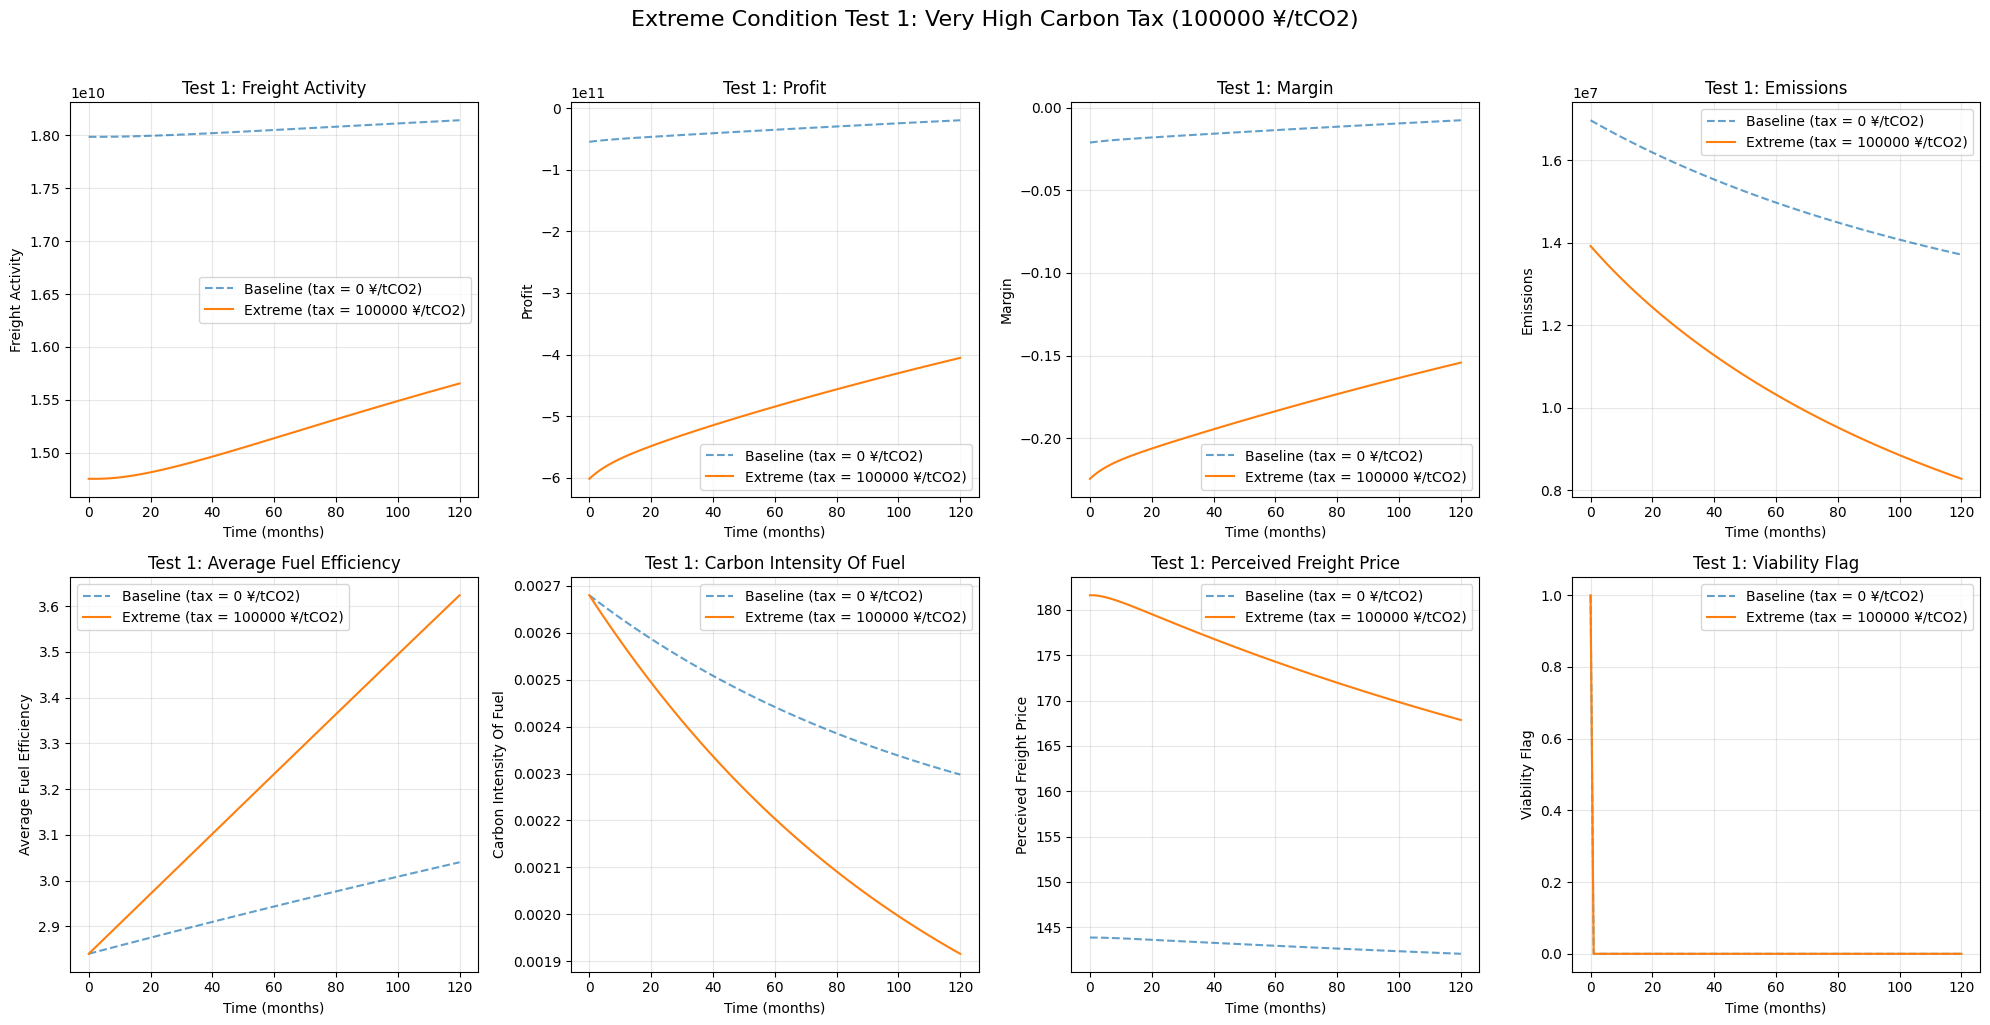

In [350]:
extreme_result = model.run(
    params={"carbon_tax_rate": 100000},
    return_columns=return_columns
)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(return_columns):
    baseline_result[col].plot(ax=axes[idx], label="Baseline (tax = 0 ¥/tCO2)", linestyle="--", alpha=0.7)
    extreme_result[col].plot(ax=axes[idx], label="Extreme (tax = 100000 ¥/tCO2)")
    axes[idx].set_title(f"Test 1: {col.replace('_', ' ').title()}")
    axes[idx].set_xlabel("Time (months)")
    axes[idx].set_ylabel(col.replace('_', ' ').title())
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle("Extreme Condition Test 1: Very High Carbon Tax (100000 ¥/tCO2)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Test 2: Very Low Demand


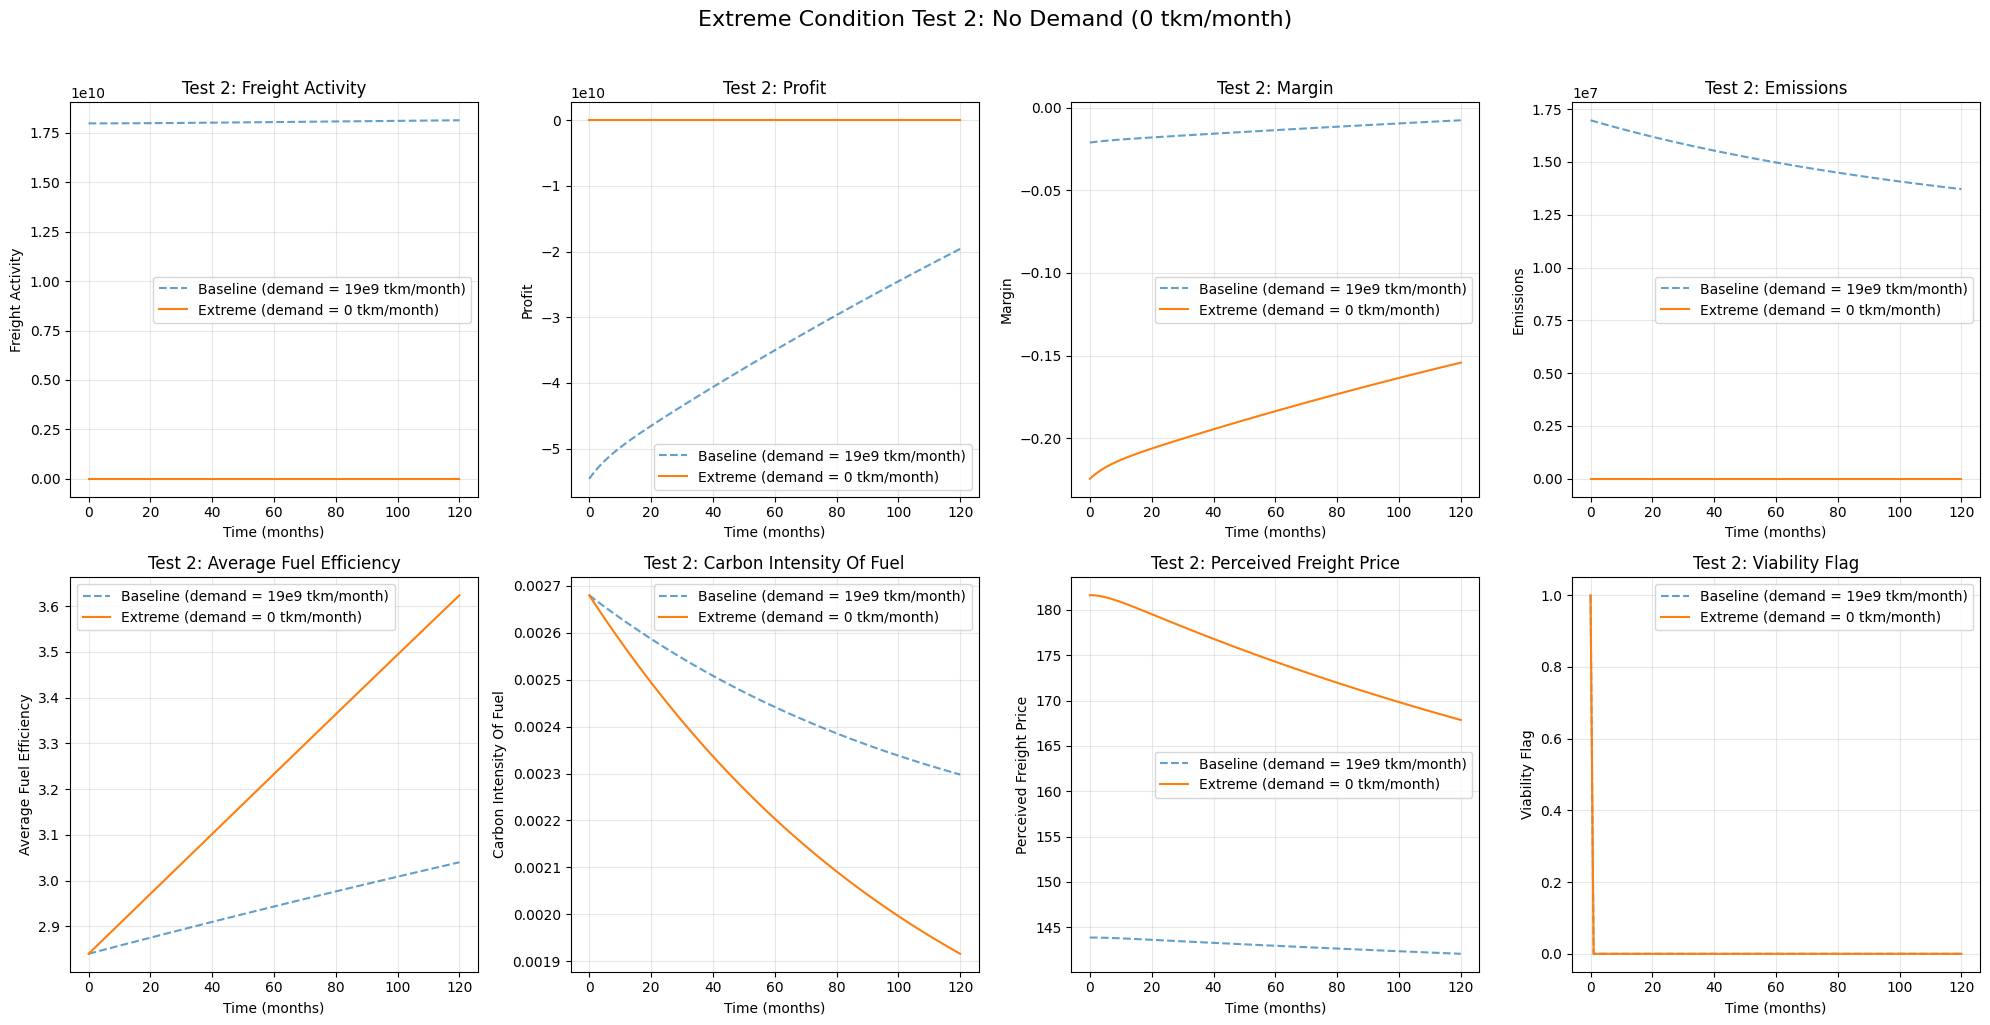

In [351]:
extreme_result = model.run(
    params={"baseline_demand": 0.1},
    return_columns=return_columns
)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(return_columns):
    baseline_result[col].plot(ax=axes[idx], label="Baseline (demand = 19e9 tkm/month)", linestyle="--", alpha=0.7)
    extreme_result[col].plot(ax=axes[idx], label="Extreme (demand = 0 tkm/month)")
    axes[idx].set_title(f"Test 2: {col.replace('_', ' ').title()}")
    axes[idx].set_xlabel("Time (months)")
    axes[idx].set_ylabel(col.replace('_', ' ').title())
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle("Extreme Condition Test 2: No Demand (0 tkm/month)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Test 3: Very Low Fuel Cost


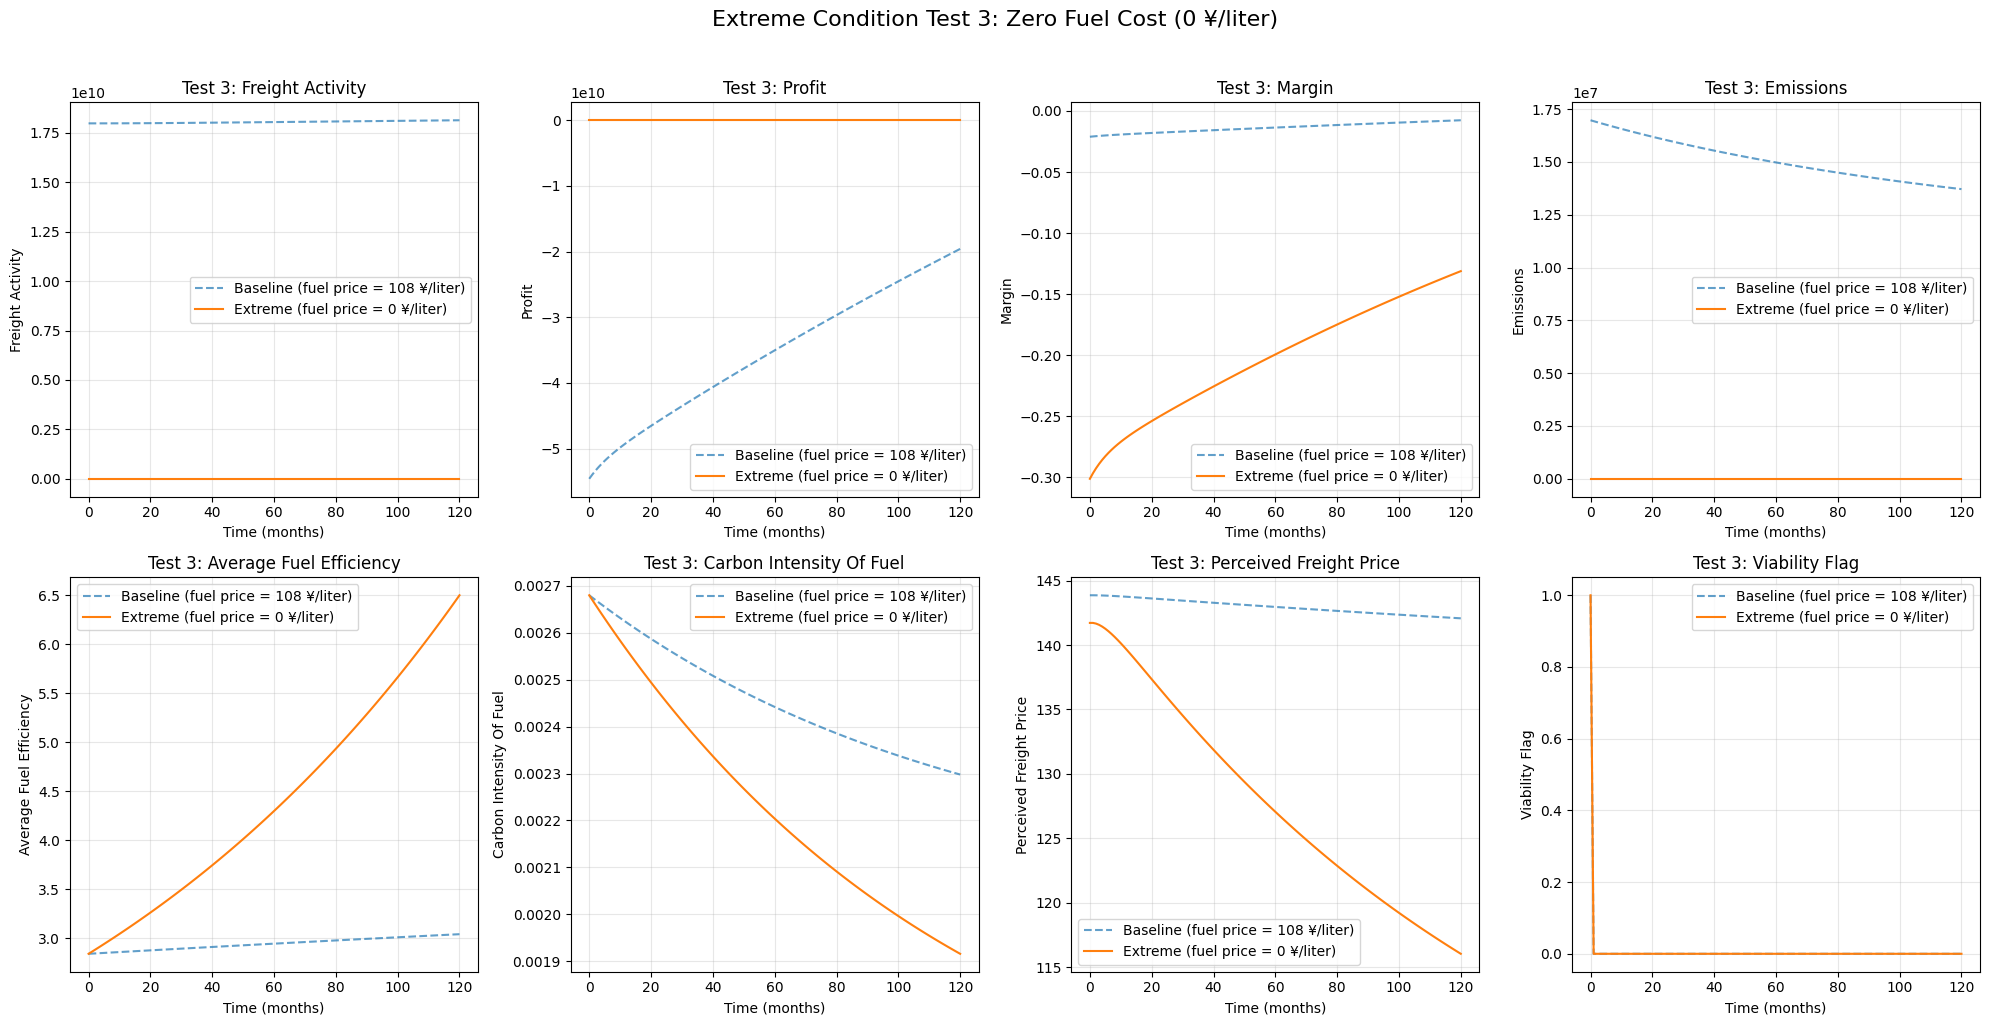

In [352]:
extreme_result = model.run(
    params={"pretax_fuel_price": 0.1},
    return_columns=return_columns
)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(return_columns):
    baseline_result[col].plot(ax=axes[idx], label="Baseline (fuel price = 108 ¥/liter)", linestyle="--", alpha=0.7)
    extreme_result[col].plot(ax=axes[idx], label="Extreme (fuel price = 0 ¥/liter)")
    axes[idx].set_title(f"Test 3: {col.replace('_', ' ').title()}")
    axes[idx].set_xlabel("Time (months)")
    axes[idx].set_ylabel(col.replace('_', ' ').title())
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle("Extreme Condition Test 3: Zero Fuel Cost (0 ¥/liter)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Test 4: Very High Demand


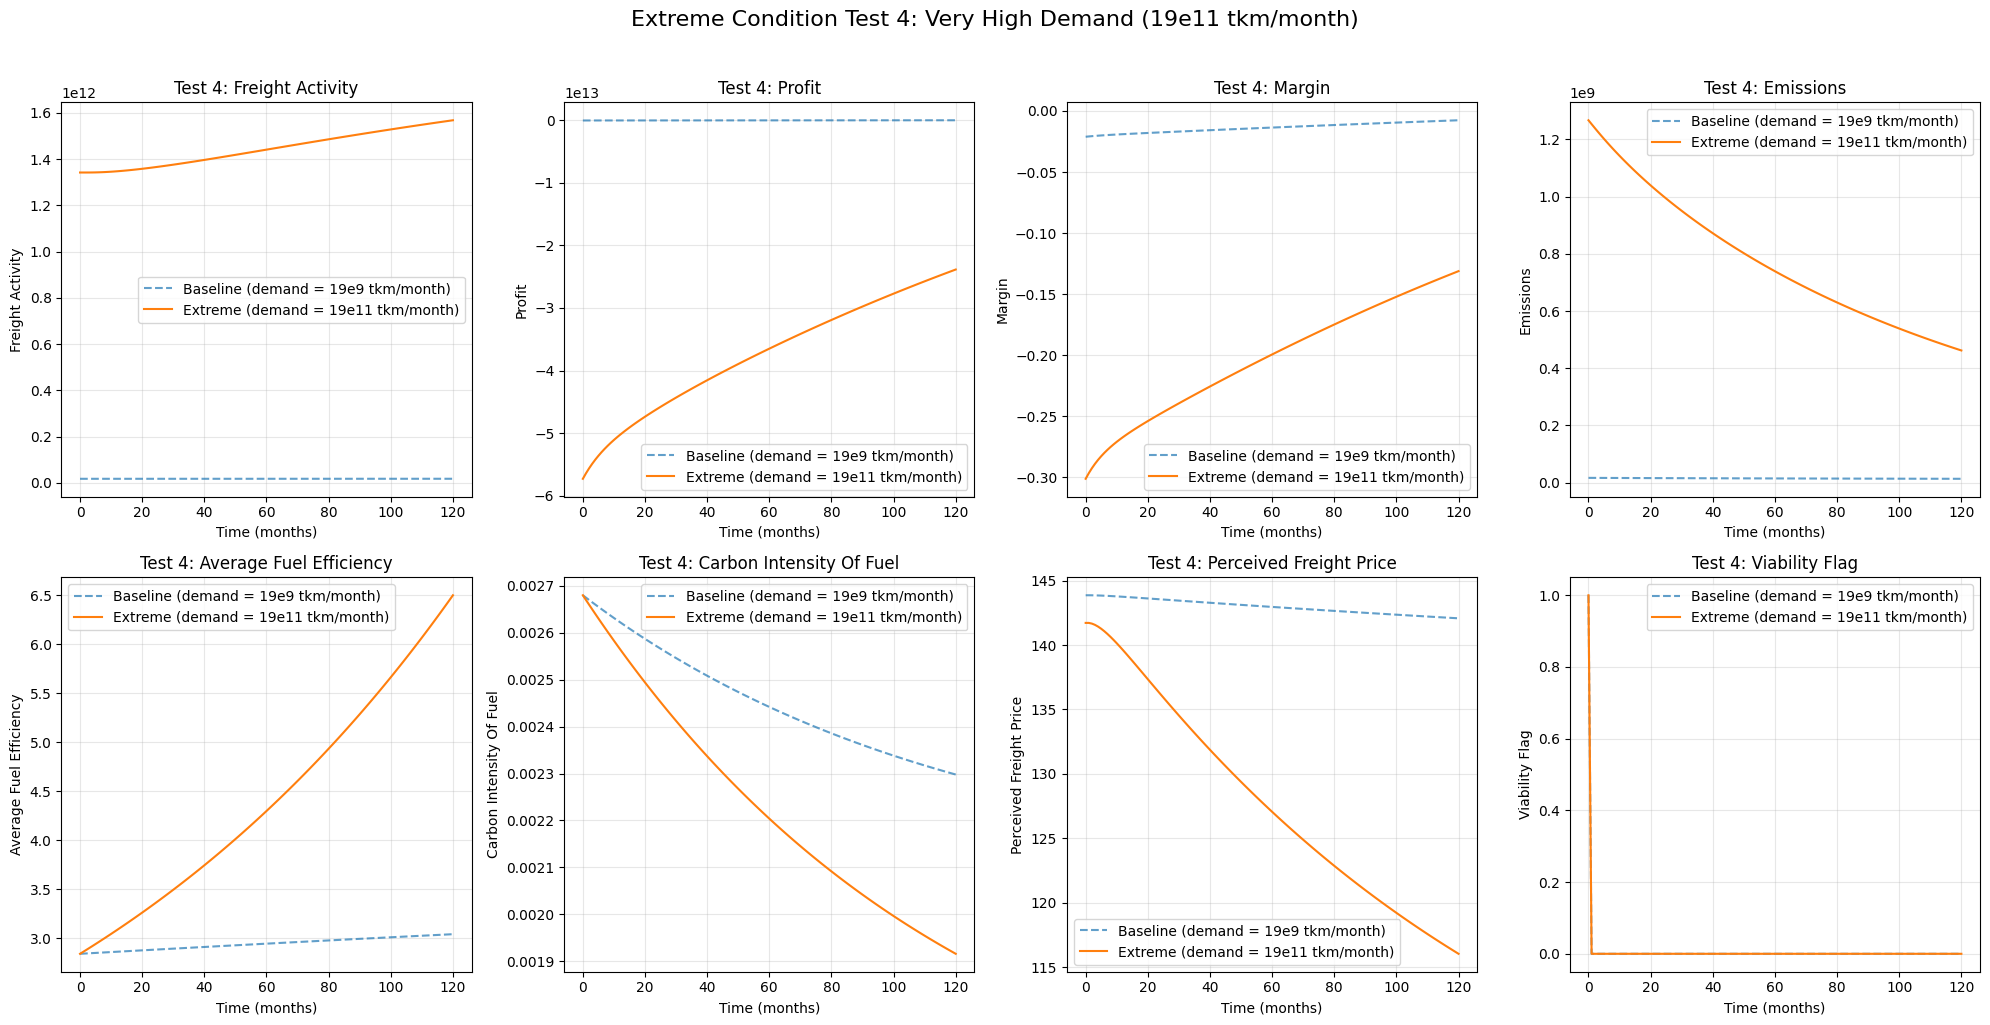

In [353]:
extreme_result = model.run(
    params={"baseline_demand": 19 * 10**11},
    return_columns=return_columns
)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, col in enumerate(return_columns):
    baseline_result[col].plot(ax=axes[idx], label="Baseline (demand = 19e9 tkm/month)", linestyle="--", alpha=0.7)
    extreme_result[col].plot(ax=axes[idx], label="Extreme (demand = 19e11 tkm/month)")
    axes[idx].set_title(f"Test 4: {col.replace('_', ' ').title()}")
    axes[idx].set_xlabel("Time (months)")
    axes[idx].set_ylabel(col.replace('_', ' ').title())
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle("Extreme Condition Test 4: Very High Demand (19e11 tkm/month)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Sensitivity Analysis

This section will test the sensitivity of the following outcome metrics:
- **Max viable tax:** Highest carbon tax where viability flag stays 1 over 10 years.
- **CO2 reduction:** Reduction in cumulative CO2 at year 10 (using `carbon_tax_rate = 5000`).
- **Average margin:** Average margin over 10 years at baseline tax.

Furthermore, it will vary the following parameters:
- `desired_pass_trough_share`
- `elasticity_sr`
- `elasticity_lr`
- `max_efficiency`
- `max_reduction_ci`
- `cost_pressure_sensitivity`

In [354]:
test_params = {
    'desired_passthrough_share': [0.3, 0.5, 0.7],
    'elasticity_sr': [-0.1, -0.2, -0.3],
    'elasticity_lr': [-0.4, -0.6, -1.0],
    'max_efficiency': [1.2, 1.25, 1.3],
    'max_reduction_ci': [0.3, 0.45, 0.6],
    'cost_pressure_sensitivity': [0.1, 0.2, 0.3]
}

In [355]:
# Helper functions to compute the outcome metrics for sensitivity analysis

def calculate_max_viable_tax(model, param_name, param_value, tax_range=None, final_time=120):
    """
    Find the highest carbon tax where viability_flag stays 1 over the simulation period.
    Uses binary search for efficiency.
    """
    result_zero = model.run(
        params={param_name: param_value, "carbon_tax_rate": 0},
        return_columns=["viability_flag"]
    )
    if not (result_zero["viability_flag"] == 1).all():
        return 0
    
    if tax_range is None:
        tax_range = (0, 30000)  # Start with a reasonable range
    
    low, high = tax_range
    best_tax = 0
    
    # Binary search for max viable tax
    while high - low > 100:  # Stop when range is small enough
        mid = (low + high) // 2
        result = model.run(
            params={param_name: param_value, "carbon_tax_rate": mid},
            return_columns=["viability_flag"]
        )
        
        # Check if viability stays 1 throughout
        if (result["viability_flag"] == 1).all():
            best_tax = mid
            low = mid
        else:
            high = mid
    
    # Fine-tune in the final range
    for tax in range(int(low), int(high) + 1, 100):
        result = model.run(
            params={param_name: param_value, "carbon_tax_rate": tax},
            return_columns=["viability_flag"]
        )
        if (result["viability_flag"] == 1).all():
            best_tax = tax
        else:
            break
    
    return best_tax

def calculate_co2_reduction(model, param_name, param_value, tax_rate=5000, final_time=120):
    """
    Calculate reduction in cumulative CO2 at final time compared to baseline (tax=0).
    """
    baseline_result = model.run(
        params={param_name: param_value, "carbon_tax_rate": 0},
        return_columns=["cumulative_co2"]
    )
    
    # With tax
    tax_result = model.run(
        params={param_name: param_value, "carbon_tax_rate": tax_rate},
        return_columns=["cumulative_co2"]
    )
    
    baseline_co2 = baseline_result["cumulative_co2"].iloc[-1]
    tax_co2 = tax_result["cumulative_co2"].iloc[-1]
    
    reduction = baseline_co2 - tax_co2
    reduction_pct = (reduction / baseline_co2 * 100) if baseline_co2 > 0 else 0
    
    return reduction, reduction_pct

def calculate_average_margin(model, param_name, param_value, baseline_tax=289, final_time=120):
    """
    Calculate average margin over the simulation period at baseline tax.
    """
    result = model.run(
        params={param_name: param_value, "carbon_tax_rate": baseline_tax},
        return_columns=["margin"]
    )
    
    return result["margin"].mean()


In [356]:
# Run sensitivity analysis for each parameter
sensitivity_results = {}

for param_name, param_values in test_params.items():
    results = {
        'param_values': [],
        'max_viable_tax': [],
        'co2_reduction': [],
        'co2_reduction_pct': [],
        'average_margin': []
    }
    
    for param_value in param_values:
        
        # Calculate max viable tax
        max_tax = calculate_max_viable_tax(model, param_name, param_value)
        results['max_viable_tax'].append(max_tax)
        
        # Calculate CO2 reduction
        co2_reduction, co2_reduction_pct = calculate_co2_reduction(model, param_name, param_value)
        results['co2_reduction'].append(co2_reduction)
        results['co2_reduction_pct'].append(co2_reduction_pct)
        
        # Calculate average margin
        avg_margin = calculate_average_margin(model, param_name, param_value)
        results['average_margin'].append(avg_margin)
        
        results['param_values'].append(param_value)
    
    sensitivity_results[param_name] = pd.DataFrame(results)
    print(f"  Completed {param_name} analysis\n")


  Completed desired_passthrough_share analysis

  Completed elasticity_sr analysis

  Completed elasticity_lr analysis

  Completed max_efficiency analysis

  Completed max_reduction_ci analysis

  Completed cost_pressure_sensitivity analysis



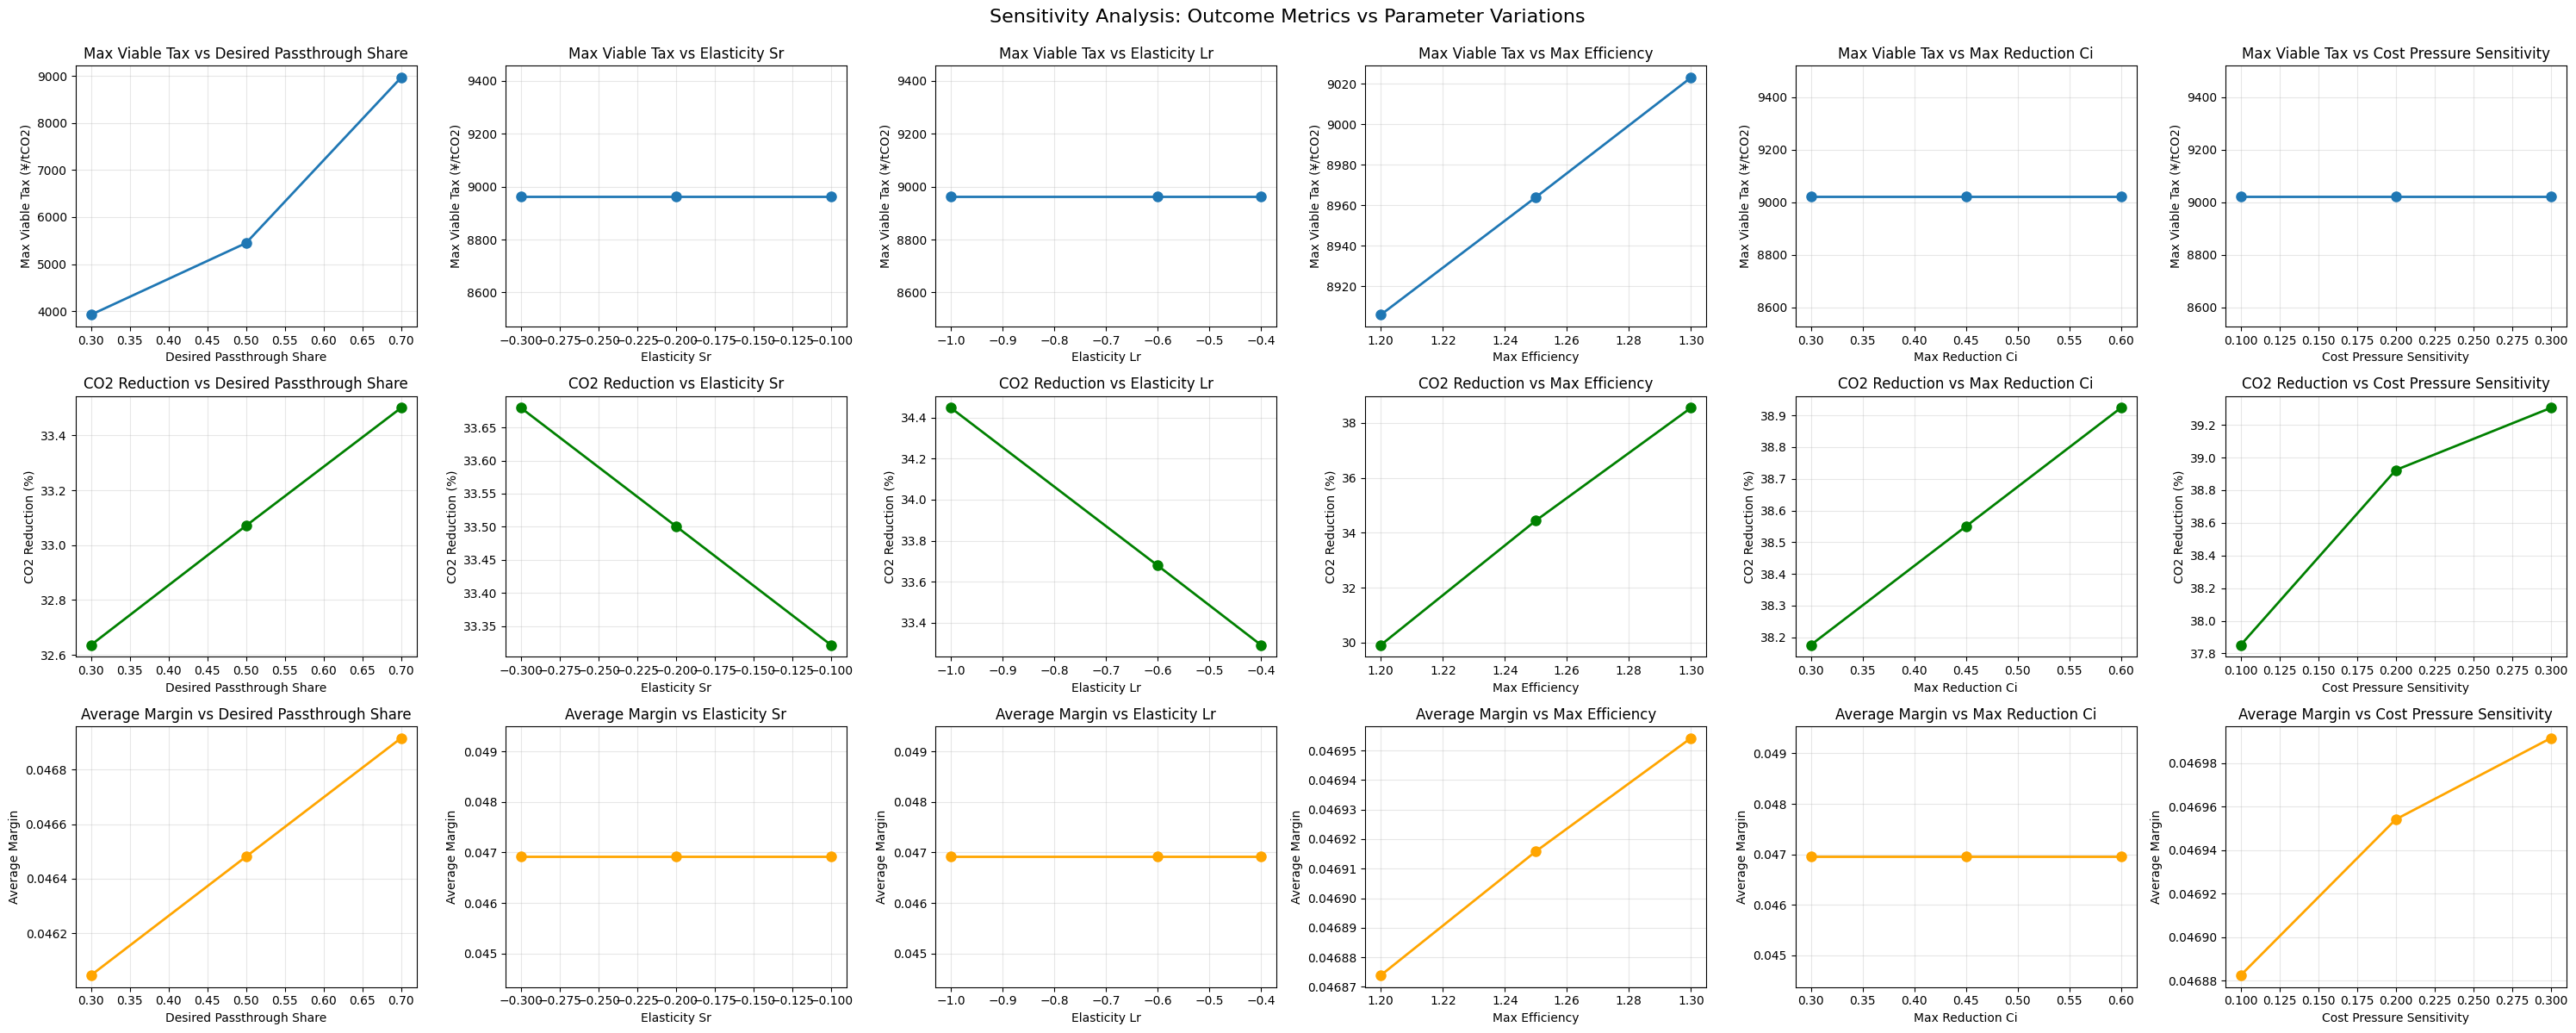

In [357]:
n_params = len(test_params)
fig, axes = plt.subplots(3, n_params, figsize=(5*n_params, 12))

param_names = list(test_params.keys())

for col_idx, param_name in enumerate(param_names):
    df = sensitivity_results[param_name]
    
    # Max viable tax
    axes[0, col_idx].plot(df['param_values'], df['max_viable_tax'], marker='o', linewidth=2, markersize=8)
    axes[0, col_idx].set_title(f'Max Viable Tax vs {param_name.replace("_", " ").title()}')
    axes[0, col_idx].set_xlabel(param_name.replace("_", " ").title())
    axes[0, col_idx].set_ylabel('Max Viable Tax (¥/tCO2)')
    axes[0, col_idx].grid(True, alpha=0.3)
    
    # CO2 reduction
    axes[1, col_idx].plot(df['param_values'], df['co2_reduction_pct'], marker='o', linewidth=2, markersize=8, color='green')
    axes[1, col_idx].set_title(f'CO2 Reduction vs {param_name.replace("_", " ").title()}')
    axes[1, col_idx].set_xlabel(param_name.replace("_", " ").title())
    axes[1, col_idx].set_ylabel('CO2 Reduction (%)')
    axes[1, col_idx].grid(True, alpha=0.3)
    
    # Average margin
    axes[2, col_idx].plot(df['param_values'], df['average_margin'], marker='o', linewidth=2, markersize=8, color='orange')
    axes[2, col_idx].set_title(f'Average Margin vs {param_name.replace("_", " ").title()}')
    axes[2, col_idx].set_xlabel(param_name.replace("_", " ").title())
    axes[2, col_idx].set_ylabel('Average Margin')
    axes[2, col_idx].grid(True, alpha=0.3)

plt.suptitle('Sensitivity Analysis: Outcome Metrics vs Parameter Variations', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


In [358]:
print("Sensitivity Analysis Summary\n" + "="*80)

for param_name in param_names:
    df = sensitivity_results[param_name]
    print(f"\n{param_name.replace('_', ' ').title()}:")
    print(df.to_string(index=False))
    print()


Sensitivity Analysis Summary

Desired Passthrough Share:
 param_values  max_viable_tax  co2_reduction  co2_reduction_pct  average_margin
          0.3            3925   7.021797e+10          32.636001        0.046046
          0.5            5448   7.115396e+10          33.071036        0.046481
          0.7            8964   7.207826e+10          33.500630        0.046916


Elasticity Sr:
 param_values  max_viable_tax  co2_reduction  co2_reduction_pct  average_margin
         -0.1            8964   7.169230e+10          33.321245        0.046916
         -0.2            8964   7.207826e+10          33.500630        0.046916
         -0.3            8964   7.246315e+10          33.679521        0.046916


Elasticity Lr:
 param_values  max_viable_tax  co2_reduction  co2_reduction_pct  average_margin
         -0.4            8964   7.163021e+10          33.292386        0.046916
         -0.6            8964   7.246315e+10          33.679521        0.046916
         -1.0            8964